<a href="https://colab.research.google.com/github/neqkir/attention-mechanism/blob/main/transformers_multihead_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer and multi-head attention

In this notebook we will be implementing a (slightly modified version) of the Transformer model from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. All images in this notebook will be taken from the Transformer paper. 

![](https://github.com/neqkir/attention-mechanism/blob/main/assets/transformer1.png?raw=1)

## Introduction

Similar to the Convolutional Sequence-to-Sequence model, the Transformer does not use any recurrence. It also does not use any convolutional layers. Instead the model is entirely made up of linear layers, attention mechanisms and normalization. 

As of January 2020, Transformers are the dominant architecture in NLP and are used to achieve state-of-the-art results for many tasks and it appears as if they will be for the near future. 

The most popular Transformer variant is [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) and pre-trained versions of BERT are commonly used to replace the embedding layers - if not more - in NLP models. 

A common library used when dealing with pre-trained transformers is the [Transformers](https://huggingface.co/transformers/) library, see [here](https://huggingface.co/transformers/pretrained_models.html) for a list of all pre-trained models available.

The differences between the implementation in this notebook and the paper are:
- we use a learned positional encoding instead of a static one
- we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps
- we do not use label smoothing

We make all of these changes as they closely follow BERT's set-up and the majority of Transformer variants use a similar set-up.

For more information about the Transformer, [see](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [these](https://jalammar.github.io/illustrated-transformer/) [three](http://nlp.seas.harvard.edu/2018/04/03/attention.html) articles.

# Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

import spacy.cli 
spacy.cli.download("de_core_news_sm")

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
#creating the tokenizer
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [4]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True) # data to be fed with the batch dimension first

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

# Load dataset, build vocabulary

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


100%|██████████| 1.21M/1.21M [00:02<00:00, 475kB/s]


downloading validation.tar.gz


100%|██████████| 46.3k/46.3k [00:00<00:00, 165kB/s]


downloading mmt_task1_test2016.tar.gz


100%|██████████| 66.2k/66.2k [00:00<00:00, 156kB/s]


In [5]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Building the Model

Next, we'll build the model. Like previous notebooks it is made up of an *encoder* and a *decoder*, with the encoder *encoding* the input/source sentence (in German) into *context vector* and the decoder then *decoding* this context vector to output our output/target sentence (in English). 

### Encoder

Similar to the ConvSeq2Seq model, the Transformer's encoder does not attempt to compress the entire source sentence, $X = (x_1, ... ,x_n)$, into a single context vector, $z$. Instead it produces a sequence of context vectors, $Z = (z_1, ... , z_n)$. So, if our input sequence was 5 tokens long we would have $Z = (z_1, z_2, z_3, z_4, z_5)$. Why do we call this a sequence of context vectors and not a sequence of hidden states? A hidden state at time $t$ in an RNN has only seen tokens $x_t$ and all the tokens before it. However, each context vector here has seen all tokens at all positions within the input sequence.

![](https://github.com/neqkir/attention-mechanism/blob/main/assets/transformer-encoder.png?raw=1)
First, the tokens are passed through a standard embedding layer. Next, as the model does not use recurrent neural networks it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a *positional embedding layer*. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence, starting with the first token, the `<sos>` (start of sequence) token, in position 0. The position embedding has a "vocabulary" size of 100, which means our model can accept sentences up to 100 tokens long. This can be increased if we want to handle longer sentences.

The original Transformer implementation from the Attention is All You Need paper does not learn positional embeddings. Instead it uses a fixed static embedding. Modern Transformer architectures, like BERT, use positional embeddings instead, hence we have decided to use them in these tutorials. Check out [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) section to read more about the positional embeddings used in the original Transformer model.

Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence. However, before they are summed, the token embeddings are multiplied by a scaling factor which is $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size, `hid_dim`. This supposedly reduces variance in the embeddings and the model is difficult to train reliably without this scaling factor. Dropout is then applied to the combined embeddings.

The combined embeddings are then passed through $N$ *encoder layers* to get $Z$, which is then output and can be used by the decoder.

The source mask, `src_mask`, masks out uninformative tokens to the attention mechanisms. It is  the same shape as the source sentence but has a value of 1 when the token in the source sentence is not a `<pad>` token and 0 when it is a `<pad>` token.  

In [8]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        # standard embedding layer
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        # position embedding layer, its inputs are the positions of the tokens
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        # N encoder layers for our tranformers
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        # dropout to be applied to the summed embeddings
        self.dropout = nn.Dropout(dropout)
        
        # scaling factor applied to the embeddings to reduce variance 
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        # src sums our standard and positional embeddings plus applying some scaling
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Encoder Layer

We first pass the source sentence and its mask into the *multi-head attention layer*, then perform dropout on it, apply a residual connection and pass it through a [Layer Normalization](https://arxiv.org/abs/1607.06450) layer. We then pass it through a *position-wise feedforward* layer and then, again, apply dropout, a residual connection and then layer normalization to get the output of this layer which is fed into the next layer. The parameters are not shared between layers. 

The mutli head attention layer is used by the encoder layer to attend to the source sentence, i.e. it is calculating and applying attention over itself instead of another sequence, hence we call it *self attention*.

[This](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) article goes into more detail about layer normalization, but the gist is that it normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Mutli Head Attention Layer

One of the key, novel concepts introduced by the Transformer paper is the *multi-head attention layer*. 
 
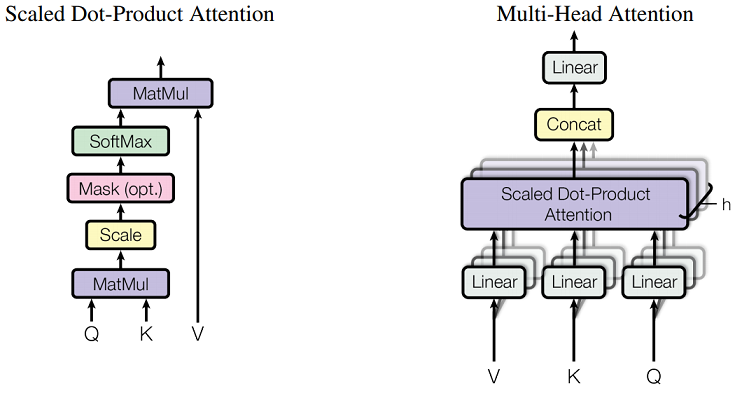

Attention can be though of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.

The Transformer uses *scaled dot-product attention*, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $d_k$ before finally then multiplying by the value. $d_k$ is the *head dimension*, `head_dim`, which we will shortly explain further.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

However, [see picture on the right] the scaled dot-product attention isn't simply applied to the queries, keys and values. Instead of doing a single attention application the queries, keys and values have their `hid_dim` split into $h$ *heads* and the scaled dot-product attention is calculated over all heads in parallel. This means instead of paying attention to one concept per attention application, we pay attention to $h$. We then re-combine the heads into their `hid_dim` shape, thus each `hid_dim` is potentially paying attention to $h$ different concepts.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

Walking through the module, first we calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v`, to give us `Q`, `K` and `V`. Next, we split the `hid_dim` of the query, key and value into `n_heads` using `.view` and correctly permute them so they can be multiplied together. We then calculate the `energy` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calulated as `hid_dim / n_heads`. We then mask the energy so we do not pay attention over any elements of the sequeuence we shouldn't, then apply the softmax and dropout. We then apply the attention to the value heads, `V`, before combining the `n_heads` together. Finally, we multiply this $W^O$, represented by `fc_o`. 


In [10]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
        
        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.        
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, `attention`, with `V` we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using `torch.matmul` which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor. This will be a **[query len, key len] x [value len, head dim]** batched matrix multiplication over the batch size and each head which provides the **[batch size, n heads, query len, head dim]** result.

One thing that looks strange at first is that dropout is applied directly to the attention. This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout. This is never explained, or even mentioned, in the paper however is used by the [official implementation](https://github.com/tensorflow/tensor2tensor/) and every Transformer implementation since, [including BERT](https://github.com/google-research/bert/).

# Position-wise Feedforward Layer

The other main block inside the encoder layer is the position-wise feedforward layer This is relatively simple compared to the multi-head attention layer. The input is transformed from `hid_dim` to `pf_dim`, where `pf_dim` is usually a lot larger than `hid_dim`. The original Transformer used a hid_dim of 512 and a pf_dim of 2048. The ReLU activation function and dropout are applied before it is transformed back into a hid_dim representation.

Why is this used? Unfortunately, it is never explained in the paper.

BERT uses the GELU activation function, which can be used by simply switching torch.relu for F.gelu. Why did they use GELU? Again, it is never explained.

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

The objective of the decoder is to take the encoded representation of the source sentence, $Z$, and convert it into predicted tokens in the target sentence, $\hat{Y}$. We then compare $\hat{Y}$ with the actual tokens in the target sentence, $Y$, to calculate our loss, which will be used to calculate the gradients of our parameters and then use our optimizer to update our weights in order to improve our predictions. 

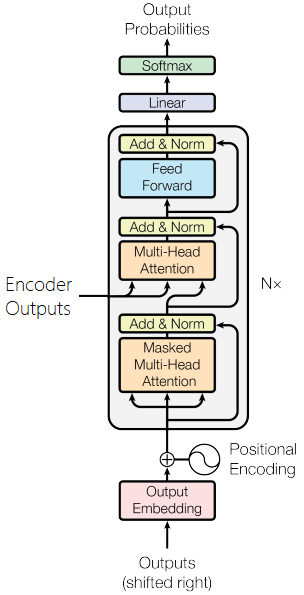

The decoder is similar to encoder, however it now has two multi-head attention layers. A *masked multi-head attention layer* over the target sequence, and a multi-head attention layer which uses the decoder representation as the query and the encoder representation as the key and value.

The decoder uses positional embeddings and combines - via an elementwise sum - them with the scaled embedded target tokens, followed by dropout. Again, our positional encodings have a "vocabulary" of 100, which means they can accept sequences up to 100 tokens long.  

The combined embeddings are then passed through the $N$ decoder layers, along with the encoded source, `enc_src`, and the source and target masks. Note that the number of layers in the encoder does not have to be equal to the number of layers in the decoder, even though they are both denoted by $N$.

The decoder representation after the $N^{th}$ layer is then passed through a linear layer, `fc_out`. In PyTorch, the softmax operation is contained within our loss function, so we do not explicitly need to use a softmax layer here.

Our decoder layer also outputs the normalized attention values so we can later plot them to see what our model is actually paying attention to.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention